# Problem 1: Random Walk Monte Carlo

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Write your own Random Walk MCMC algorithm from scratch. Don't worry if it is slow or inefficient - this exercise is about intuition building, not results. Use your sampler to fit a line to the data and generate samples from the posterior. For a first pass, run the sampler for a fixed number of steps, $N$. Then, modify the sampler to automatically stop running when a target number of effective samples $N_{\rm eff}$ has been reached.

# Problem 2: Fitting a Line

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

a) Fit the data using an ensemble sampler of your choice (recommendation: `emcee`)

b) Fit the data using a Hamiltonian Monte Carlo Sampler of your choice (recommendation: `PyMC` or `NumPyro`)

c) Fit the data using a nested sampler of your choice (recommendation: `dynesty`, `UltraNest`)

For all three cases, explicity write down the likelihood function; the `emcee` documentation has a clear explanation of how to do this. For Nested Sampling, you will also need to write a prior transform function; the `dynesty` documentation has a clear explanation of how to do this. Play around with using different priors (e.g. Gaussian, Uniform, Log-Uniform) to get a feel for the syntax of the different packages.

In [5]:
import dynesty as dyn
import pymc
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('line_fitting.csv')

<ErrorbarContainer object of 3 artists>

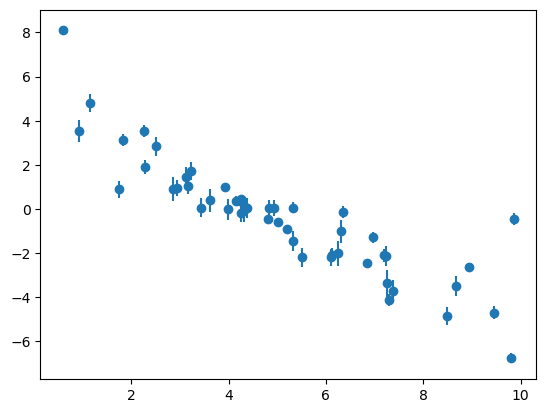

In [7]:
plt.errorbar(data['x'],data['y'],yerr=data['y_err'],fmt='o')

In [10]:
def model(theta,x):
    m = theta[0]
    b = theta[1]
    return x*m + b

def log_prior(theta):
    if -10 < theta[0] < 10 or -10 < theta[1] < 10:
        return 0.0
    else:
        return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    return -0.5 * np.sum(((y - model) / yerr)**2)
    
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [11]:
pos = 4 + -2 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(data['x'],data['y'], data['y_err'])
)
sampler.run_mcmc(pos, 100, progress=True);

You must install the tqdm library to use progress indicators with emcee


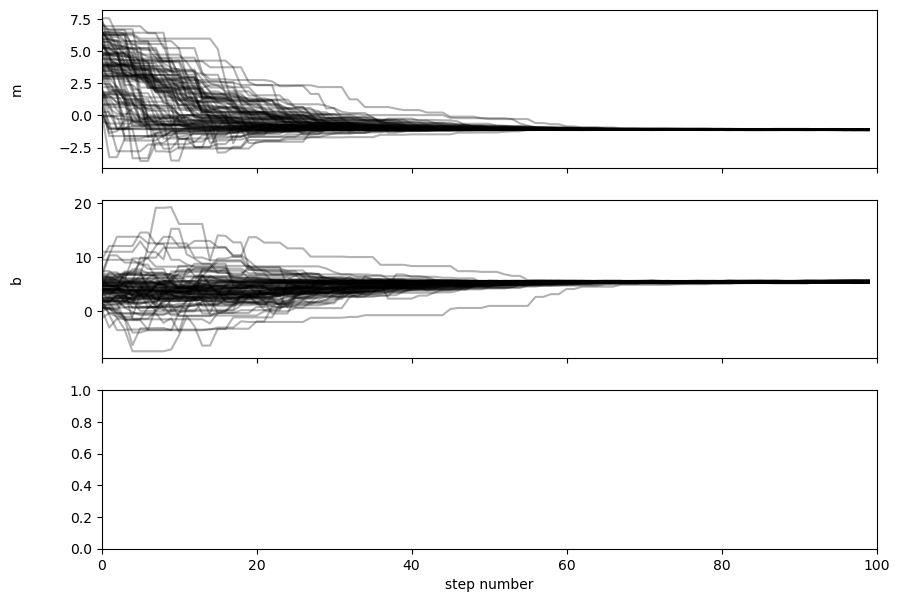

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
plt.figure(figsize=(8.5,8.5))


<Figure size 850x850 with 0 Axes>

<Figure size 850x850 with 0 Axes>

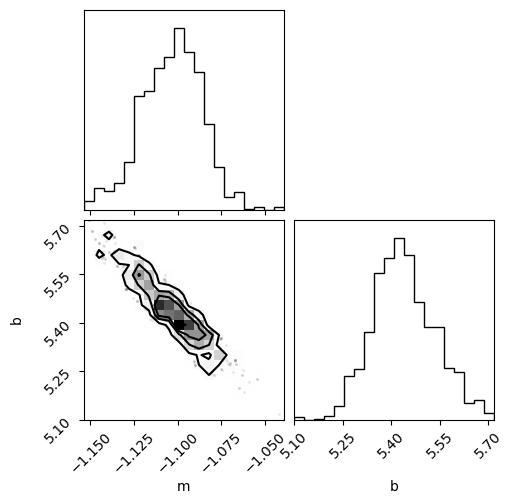

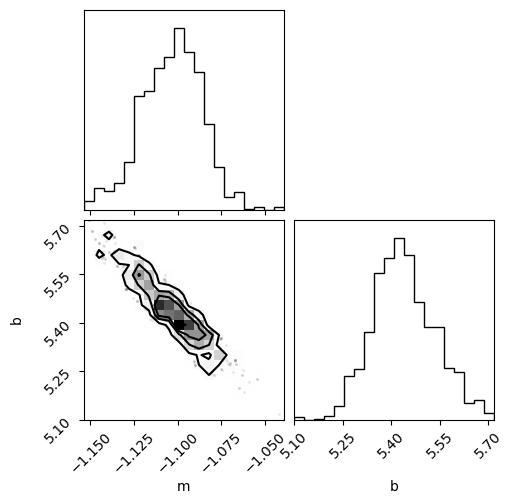

In [15]:
samples_last_10 = samples[-10:,:,:]
import corner
corner.corner(samples_last_10,labels=['m','b'])


## 

In [16]:
import pymc as pm

In [19]:

with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    intercept = pm.Uniform("b",rng=[-10,10])
    slope = pm.Uniform("m", rng=[-10,10])

    b = 4
    m = -2
    y = b + m*np.random.randn(100,1)
    # Define likelihood
    likelihood = pm.Normal("y", initval=mu=intercept + slope * data['x'], observed=data['y'])

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1 seconds.


In [24]:
idata.posterior['y_model'] = idata.posterior['b'] + (idata.posterior['m']*np.linspace(0,10,3000))
                                                     

In [25]:
import arviz as az


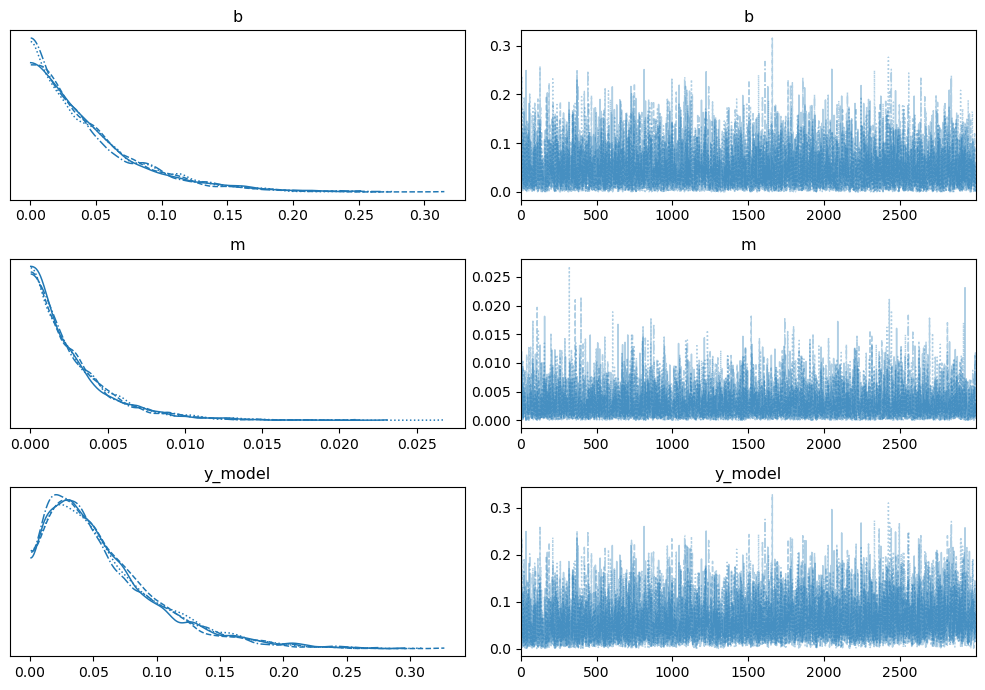

In [27]:
az.plot_trace(idata, figsize=(10, 7))
plt.tight_layout()

# Problem 3: Astrophysics

Select an astrophysical dataset of your choosing. Fit the data using (a) an ensemble sampler, (b) HMC, and (c) Nested Sampling. Verify that the three methods produce equivalent results.